In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ase.io import read
from ase.visualize import view
import matplotlib.pyplot as plt
import numpy as np 
import torch 
torch.set_default_dtype(torch.float64)

import rascaline.torch

import metatensor.torch as mts

from metatensor.torch import Labels, TensorBlock, TensorMap
from metatensor.learn import IndexedDataset, DataLoader
from metatensor.learn.data import group as mts_group, group_and_join as group_and_join_mts

from mlelec.data.dataset import PySCFPeriodicDataset, split_by_Aij_mts
from mlelec.utils.twocenter_utils import _to_coupled_basis
from mlelec.utils.pbc_utils import matrix_to_blocks, kmatrix_to_blocks, TMap_bloch_sums, precompute_phase, kblocks_to_matrix, kmatrix_to_blocks, blocks_to_matrix, matrix_to_blocks
from mlelec.utils.plot_utils import print_matrix, matrix_norm, block_matrix_norm, plot_block_errors
from mlelec.features.acdc import compute_features
from mlelec.utils.target_utils import get_targets
from mlelec.models.linear import LinearModelPeriodic
from mlelec.metrics import L2_loss, L2_loss_meanzero
import xitorch
from xitorch.linalg import symeig

from glob import glob

from scipy.linalg import eigvalsh
from pathlib import Path

/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [3]:
def compute_eigenvalues(blocks, dataset, overlap_matrices = None, baseline = None):
    
    recon_HT = blocks_to_matrix(blocks, dataset, detach = True)
    recon_Hk = dataset.bloch_sum(recon_HT)
    
    if baseline is not None:
        for Hks, H0ks in zip(recon_Hk, baseline):
            for Hk, H0k in zip(Hks, H0ks):
                Hk += H0k
    
    if overlap_matrices is not None:
        recon_Sk = overlap_matrices
        # recon_ST = blocks_to_matrix(overlap_blocks, dataset)
        # recon_Sk = dataset.bloch_sum(recon_ST)
        is_ortho = False
    else:
        is_ortho = True
        
    eigvals = []
    if is_ortho:
        for Hk in recon_Hk:
            ek = []
            for h in Hk:
                ek.append(eigvalsh(h.detach().cpu().numpy()))
            eigvals.append(np.stack(ek))
    else:
        for Hk, Sk in zip(recon_Hk, recon_Sk):
            ek = []
            for h, s in zip(Hk, Sk):
                ek.append(eigvalsh(h.detach().cpu().numpy(), b = s.detach().cpu().numpy()))
            eigvals.append(np.stack(ek))
            
    return np.stack(eigvals), torch.stack(recon_Hk)

def rmse_vector(v1, v2):
    return np.sqrt(np.mean(np.abs(v1-v2)**2))

def mae_vector(v1, v2):
    return np.mean(np.abs(v1 - v2))

In [4]:
root = '/scratch/pegolo/benchmarks'
nhidden = 64
nlayers = 1
device = 'cpu'
cutoff = 8
overwrite = True

results_dir = f'{root}/test_results'
Path(results_dir).mkdir(exist_ok = overwrite)

In [5]:
# Load test set features
test_features = mts.load(f'{root}/test/features_140_172')

# Define dataset
orbitals = {6: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]]}
orbital_names = 'sto-3g'

kmesh = [8,8,1]

START, STOP = 140, 172
indices = range(START,STOP)
frames = read(f'{root}/test/C2_174.extxyz', index = slice(START,STOP))
rfock = [np.load(f"{root}/test/data/scf/C2_174_881_{i}/realfock_{i}.npy", allow_pickle = True).item() for i in indices]
rfock0 = [np.load(f"{root}/test/data/baseline/C2_174_881_{i}/realfock_{i}.npy", allow_pickle = True).item() for i in indices]
rover = [np.load(f"{root}/test/data/scf/C2_174_881_{i}/realoverlap_{i}.npy", allow_pickle = True).item() for i in indices]

for f in frames:
    f.pbc=[True,True,False]
    f.wrap(center = (0,0,0), eps = 1e-60)
    f.pbc=True

dataset = PySCFPeriodicDataset(frames = frames,
                               kmesh = kmesh,
                               dimension = 2,
                               fock_realspace = rfock,
                               overlap_realspace = rover,
                               device = device,
                               orbs = orbitals,
                               orbs_name = orbital_names)

overlap_matrices = dataset.bloch_sum(blocks_to_matrix(mts.load(f'{root}/test/overlap_coupled_blocks'), dataset)) 
test_HT_blocks = mts.load(f'{root}/test/target_coupled_blocks')
baseline_blocks = mts.load(f'{root}/test/target_coupled_blocks0')
baseline_target = dataset.bloch_sum(blocks_to_matrix(baseline_blocks, dataset))

In [6]:
target_eigvals, target_matrices = compute_eigenvalues(test_HT_blocks, dataset, overlap_matrices = overlap_matrices)

In [9]:
# Initialize model
model = LinearModelPeriodic(twocfeat = test_features, 
                             target_blocks = test_HT_blocks,
                             frames = dataset.structures, orbitals = dataset.basis, 
                             device = device,
                             bias = True,
                             nhidden = nhidden, 
                             nlayers = nlayers,
                             activation = 'SiLU',
                             apply_norm = True)
model = model.double()

In [8]:
# Compute metrics

RMSE = {}
MAE = {}
STD = {}

for space in ['real_space', 'kspace']:

    RMSE[space] = {}
    MAE[space] = {}
    STD[space] = {}

    folders = glob(f'{root}/{space}/*')

    for folder in folders:
        
        fname = folder.split('/')[-1]

        RMSE[space][fname] = {}
        MAE[space][fname] = {}
        STD[space][fname] = {}

        if 'baseline' in fname.split('_') or 'traceless' in fname.split('_'):
            is_baseline = True
        else:
            is_baseline = False

        if 'orthogonalized' in fname.split('_'):
            is_ortho = True
        else:
            is_ortho = False

        print(f'Analyzing {fname}. is_baseline = {is_baseline}; is_ortho = {is_ortho}', flush = True)

        if is_ortho:
            overlap_mat = None
        else:
            overlap_mat = overlap_matrices

        if is_baseline:
            baseline = baseline_target
        else:
            baseline = None
        
        # Load trained models
        checkpoint = {}
        train_folders = glob(f'{folder}/train_*')
        for train_folder in train_folders:
            
            nstruc = train_folder.split('/')[-1].split('_')[2]
            
            print(f'    {nstruc} {train_folder}')

            ckpts = glob(f'{train_folder}/*ckpt')
            if len(ckpts):
                
                RMSE[space][fname][nstruc] = {}
                MAE[space][fname][nstruc] = {}
                STD[space][fname][nstruc] = {}
                
                last_model = max([int(ckpt.split('/')[-1].split('.')[0].split('_')[1]) for ckpt in ckpts])
    
                print(f'    {train_folder}: loading model trained over {last_model} epochs', flush = True)
                checkpoint[nstruc] = torch.load(f'{train_folder}/model_{last_model}.ckpt')
    
                model.load_state_dict(checkpoint[nstruc]['model_state_dict'])
    
                pred_HT_blocks = model.predict(test_features, test_HT_blocks)
    
                pred_eigvals, pred_Hk = compute_eigenvalues(pred_HT_blocks, dataset, baseline = baseline, overlap_matrices = overlap_mat)
    
                eig_dict = {'target': target_eigvals, 'prediction': pred_eigvals}
                np.save(f'{results_dir}/{fname}_eigenvalues.npy', eig_dict)

                RMSE[space][fname][nstruc]['eigvals'] = rmse_vector(target_eigvals, pred_eigvals)
                RMSE[space][fname][nstruc]['fock'] = rmse_vector(target_matrices.numpy(), pred_Hk.numpy())
                MAE[space][fname][nstruc]['eigvals'] = mae_vector(target_eigvals, pred_eigvals)
                MAE[space][fname][nstruc]['fock'] = mae_vector(target_matrices.numpy(), pred_Hk.numpy())
                STD[space][fname][nstruc]['eigvals'] = target_eigvals.flatten().std()
                STD[space][fname][nstruc]['fock'] = target_matrices.numpy().std()
                
                print(f'    RMSE {fname} {nstruc} eigvals {RMSE[space][fname][nstruc]["eigvals"]}', flush = True)
                print(f'    RMSE {fname} {nstruc} fock {RMSE[space][fname][nstruc]["fock"]}', flush = True)
    
                print(f'    MAE {fname} {nstruc} eigvals {MAE[space][fname][nstruc]["eigvals"]}', flush = True)
                print(f'    MAE {fname} {nstruc} fock {MAE[space][fname][nstruc]["fock"]}', flush = True)
            else:
                print('    Empty folder!')

Analyzing a_direct_HT. is_baseline = False; is_ortho = False
    100 /scratch/pegolo/benchmarks/real_space/a_direct_HT/train_0_100
    /scratch/pegolo/benchmarks/real_space/a_direct_HT/train_0_100: loading model trained over 950 epochs


NameError: name 'model' is not defined

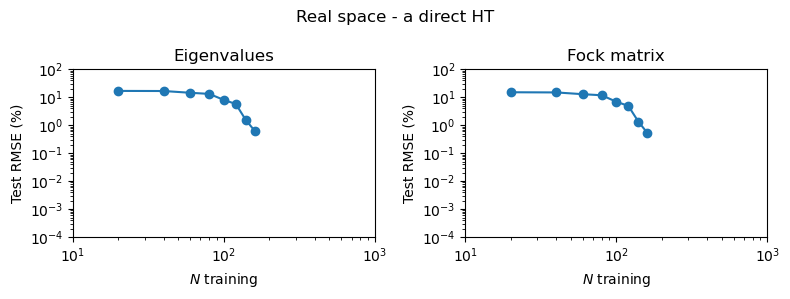

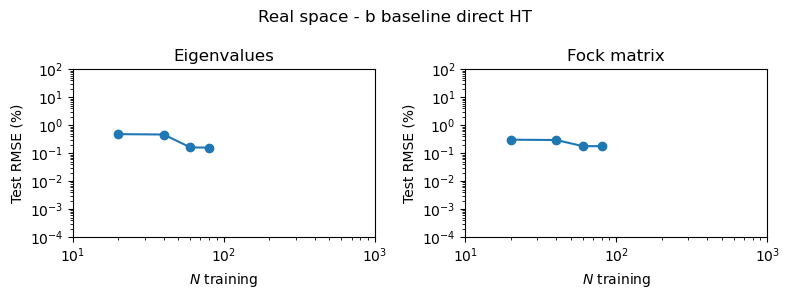

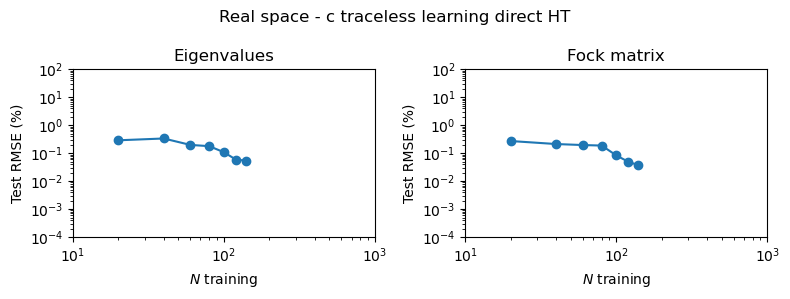

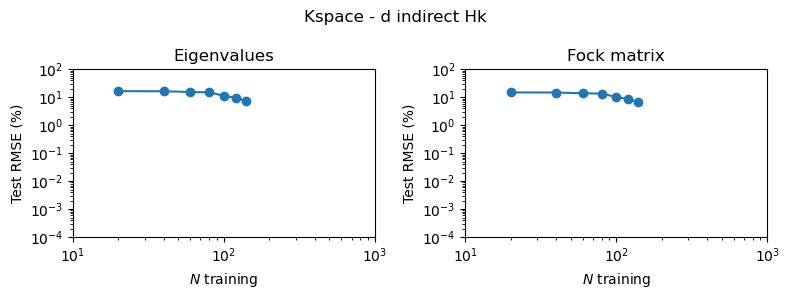

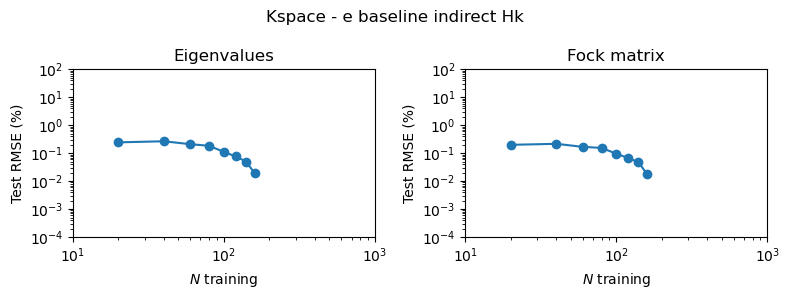

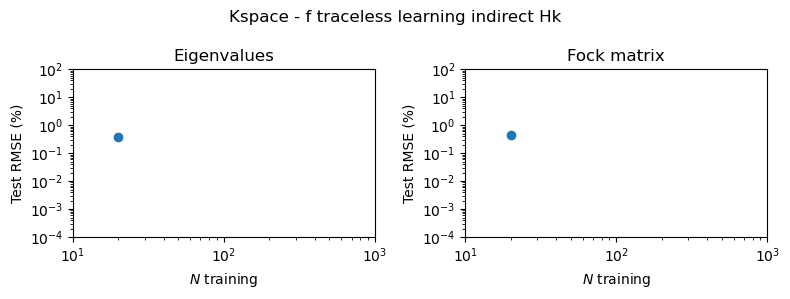

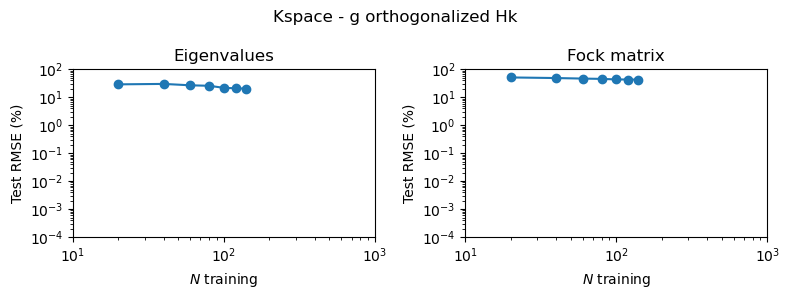

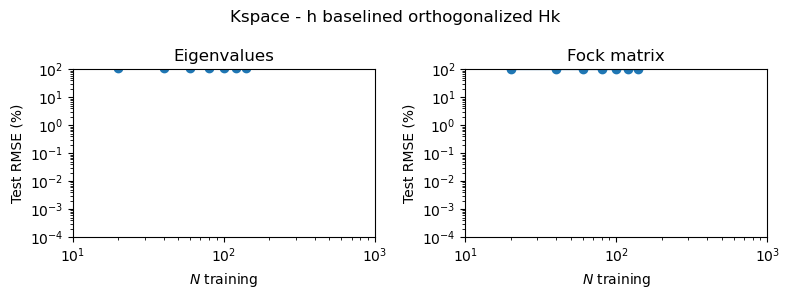

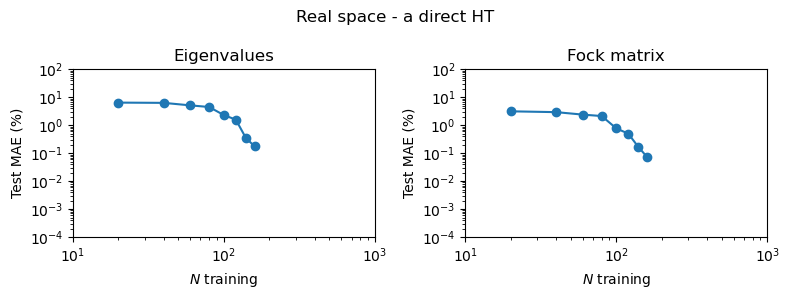

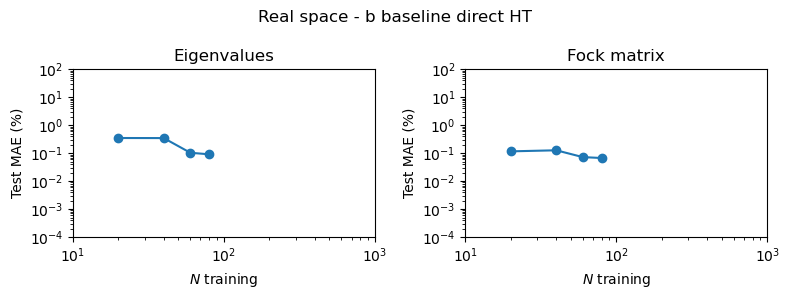

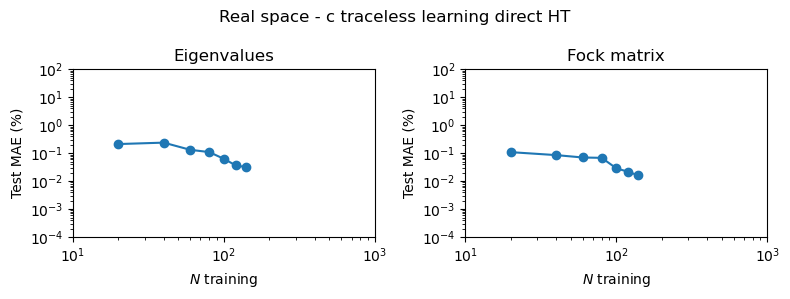

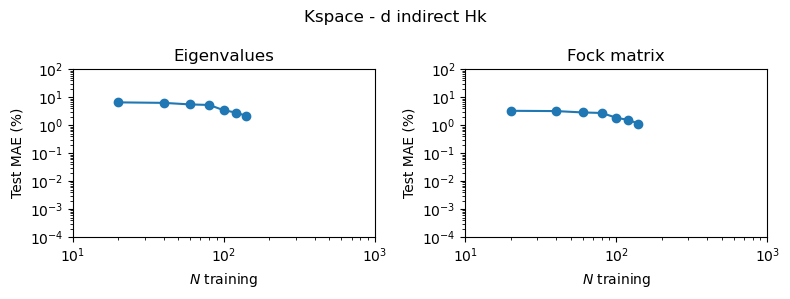

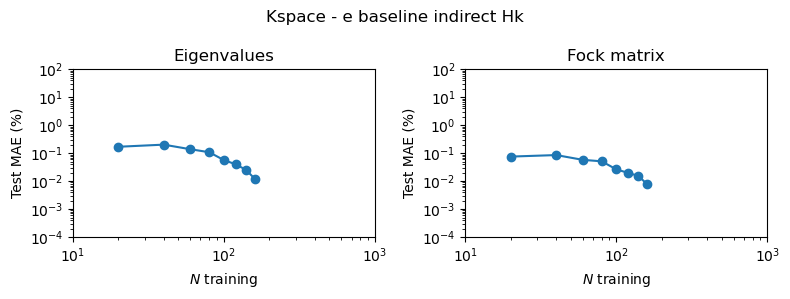

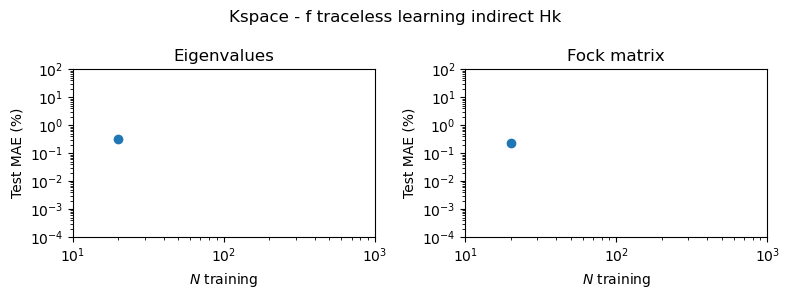

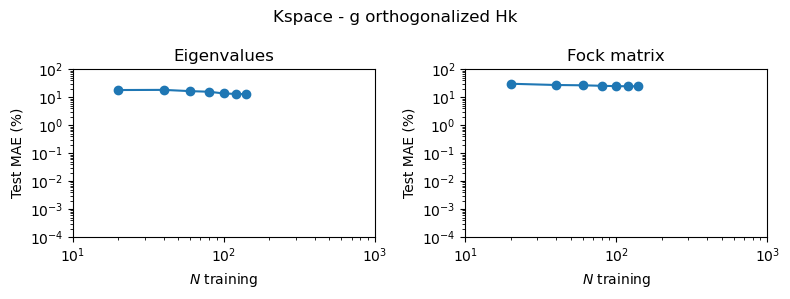

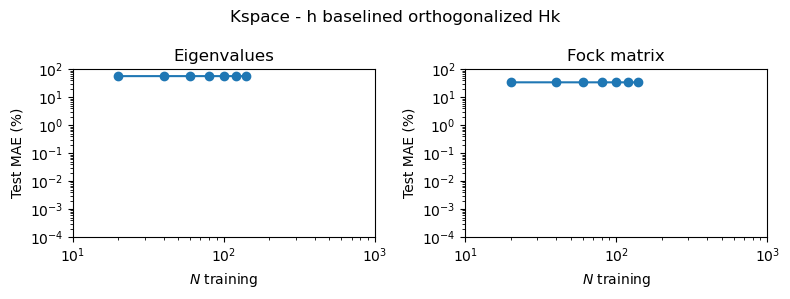

In [208]:
from ase.units import Hartree
is_relative = True
for metrics, metrics_name in zip([RMSE, MAE], ['RMSE', 'MAE']):
    
    for space in metrics:
        
        for strategy in metrics[space]:
    
            if metrics[space][strategy] == {}:
                continue
            
            fig, axes = plt.subplots(ncols = 2, figsize = (8, 3))
            
            for ax, target_quantity, target_name in zip(axes, ['eigvals', 'fock'], ['Eigenvalues', 'Fock matrix']):
                x = np.array([float(n) for n in metrics[space][strategy]])
                if is_relative:
                    y = np.array([metrics[space][strategy][n][target_quantity]/STD[space][strategy][n][target_quantity] for n in metrics[space][strategy]])*100
                    unit = '%'
                    upper = 100
                else:
                    y = np.array([metrics[space][strategy][n][target_quantity] for n in metrics[space][strategy]])*Hartree*1000
                    unit = 'meV'
                    upper = 10*Hartree*1000
                y = y[x.argsort()]
                x = x[x.argsort()]
                ax.plot(x, y, '-o')
                
                ax.set_xlabel('$N$ training')
                ax.set_ylabel(f'Test {metrics_name} ({unit})')
                
                ax.set_xscale('log')
                ax.set_yscale('log')
                ax.set_xlim(10, 1000)
                ax.set_ylim(1e-4, upper)
                
                ax.set_title(target_name)
    
            title = ' '.join(space.capitalize().split('_')) + ' - ' + ' '.join(strategy.split("_")[:])
            fig.suptitle(title)
            fig.tight_layout()

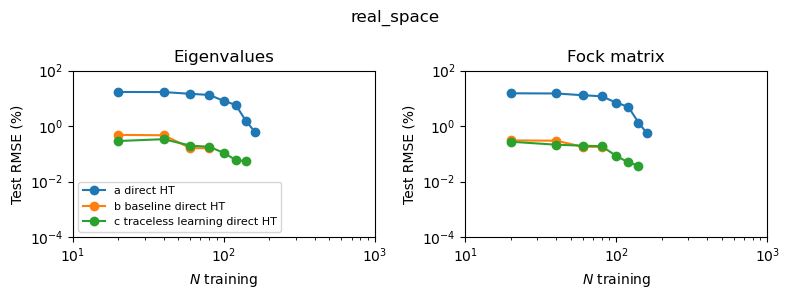

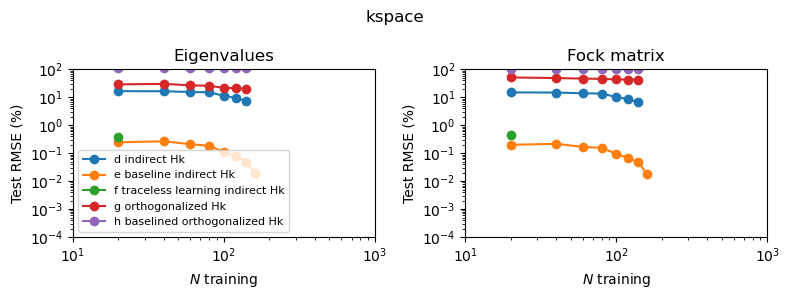

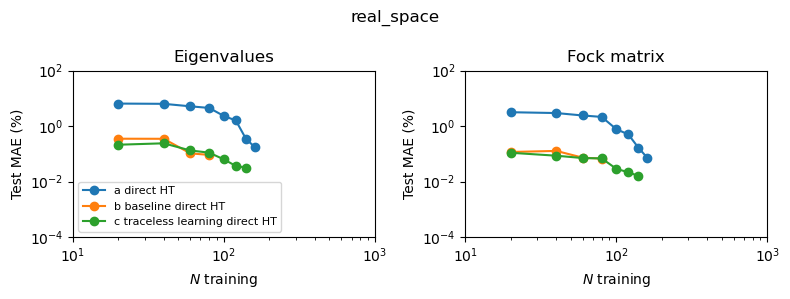

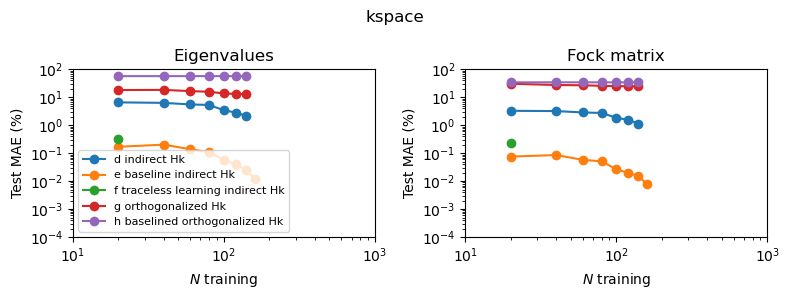

In [217]:
from ase.units import Hartree
is_relative = True
for metrics, metrics_name in zip([RMSE, MAE], ['RMSE', 'MAE']):
    
    for space in metrics:

        fig, axes = plt.subplots(ncols = 2, figsize = (8, 3))
      
        for strategy in metrics[space]:
    
            if metrics[space][strategy] == {}:
                continue
            
            
            for i, (ax, target_quantity, target_name) in enumerate(zip(axes, ['eigvals', 'fock'], ['Eigenvalues', 'Fock matrix'])):
                x = np.array([float(n) for n in metrics[space][strategy]])
                if is_relative:
                    y = np.array([metrics[space][strategy][n][target_quantity]/STD[space][strategy][n][target_quantity] for n in metrics[space][strategy]])*100
                    unit = '%'
                    upper = 100
                else:
                    y = np.array([metrics[space][strategy][n][target_quantity] for n in metrics[space][strategy]])*Hartree*1000
                    unit = 'meV'
                    upper = 10*Hartree*1000
                y = y[x.argsort()]
                x = x[x.argsort()]
                ax.plot(x, y, '-o', label = ' '.join(strategy.split("_")))
                
                ax.set_xlabel('$N$ training')
                ax.set_ylabel(f'Test {metrics_name} ({unit})')
                
                ax.set_xscale('log')
                ax.set_yscale('log')
                ax.set_xlim(10, 1000)
                ax.set_ylim(1e-4, upper)
                
                ax.set_title(target_name)

                if i == 0: ax.legend(fontsize = 8)
            # title = ' '.join(space.capitalize().split('_')) + ' - ' + ' '.join(strategy.split("_")[:])
        fig.suptitle(space)
        fig.tight_layout()

In [ ]:
!ls 

In [203]:
ed = np.load(f'/scratch/pegolo/benchmarks/test_results/b_baseline_direct_HT_eigenvalues.npy', allow_pickle = True).item()

In [21]:
ed = np.load(f'/scratch/pegolo/benchmarks/test_results/a_direct_HT_eigenvalues.npy', allow_pickle = True).item()

In [23]:
from ase.units import Hartree

[-9.74986525 -9.74630741] [-9.03749995 -9.03566247]
[-9.74865184 -9.74518287] [-9.28334262 -9.28319799]
[-9.74796889 -9.74450578] [-9.37427318 -9.37316393]
[-9.74890439 -9.74538996] [-9.06452067 -9.06289045]
[-9.75278187 -9.74919631] [-7.75212975 -7.74153522]
[-9.74794053 -9.7444656 ] [-9.38732002 -9.38601356]
[-9.74658735 -9.74317662] [-9.45924366 -9.45737034]
[-9.74953844 -9.74601489] [-8.56295764 -8.55608619]
[-9.74792629 -9.74445134] [-9.38732002 -9.38601356]
[-9.74556462 -9.7422172 ] [-9.53354345 -9.53107914]
[-9.75040875 -9.74683223] [-8.38623427 -8.37879815]
[-9.7455213  -9.74215531] [-9.50784701 -9.50554742]
[-9.7531792  -9.74951091] [-7.23134697 -7.21458385]
[-9.74672116 -9.74333909] [-9.35801048 -9.35702803]
[-9.74795426 -9.74447929] [-9.38732002 -9.38601356]
[-9.7465553  -9.74315035] [-9.47841079 -9.47632222]
[-9.74794505 -9.74447011] [-9.38732002 -9.38601356]
[-9.74971942 -9.74617002] [-8.97532368 -8.97289359]
[-9.74875487 -9.74524721] [-9.25351146 -9.25344435]
[-9.74990664

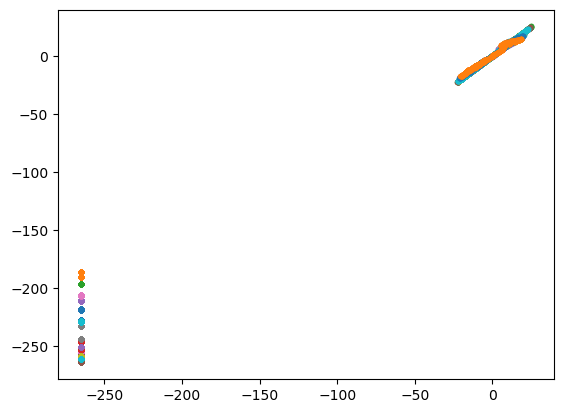

In [27]:
for ifr in range(ed['target'].shape[0]):
    x = ed['target'][ifr].flatten()
    y = ed['prediction'][ifr].flatten()
    print(x[0:2], y[0:2])
    plt.plot(x[x>-500]*Hartree, y[x>-500]*Hartree, '.', label = ifr)
# plt.legend()
# plt.plot([-10*Hartree, 2*Hartree], [-10*Hartree,2*Hartree])
# plt.plot([-10, 2])

In [197]:
ed['target'][ifr].flatten().max()

0.6753185497448873

In [221]:
train_folder

'/scratch/pegolo/benchmarks/kspace/h_baselined_orthogonalized_Hk/train_0_80'

In [10]:
from mlelec.utils.plot_utils import plot_block_errors

[6.87412393e-05 8.30776005e+00 6.71552965e+00 7.55353523e-01
 7.78988650e+01 2.13482414e+01 4.86062299e-03 1.04085114e+01
 1.60257502e-01 3.51469664e+00 1.31392547e+00 3.16546574e-04
 4.98979335e+00 1.43837402e-04 6.98281590e+00 3.58865751e-01
 1.33224352e+00 4.95728979e+00] [6.87412340e-05 4.18055448e-02 2.13065428e-02 1.56766816e-02
 1.06350823e+00 2.34852879e-01 4.86062299e-03 7.34055768e-02
 9.83914518e-03 1.77252991e-02 1.33025219e-02 3.34130742e-04
 2.13948447e-02 1.43837402e-04 2.74957797e-02 1.84093008e-03
 8.32937064e-03 1.80359072e-02]


(1e-18, 1000.0)

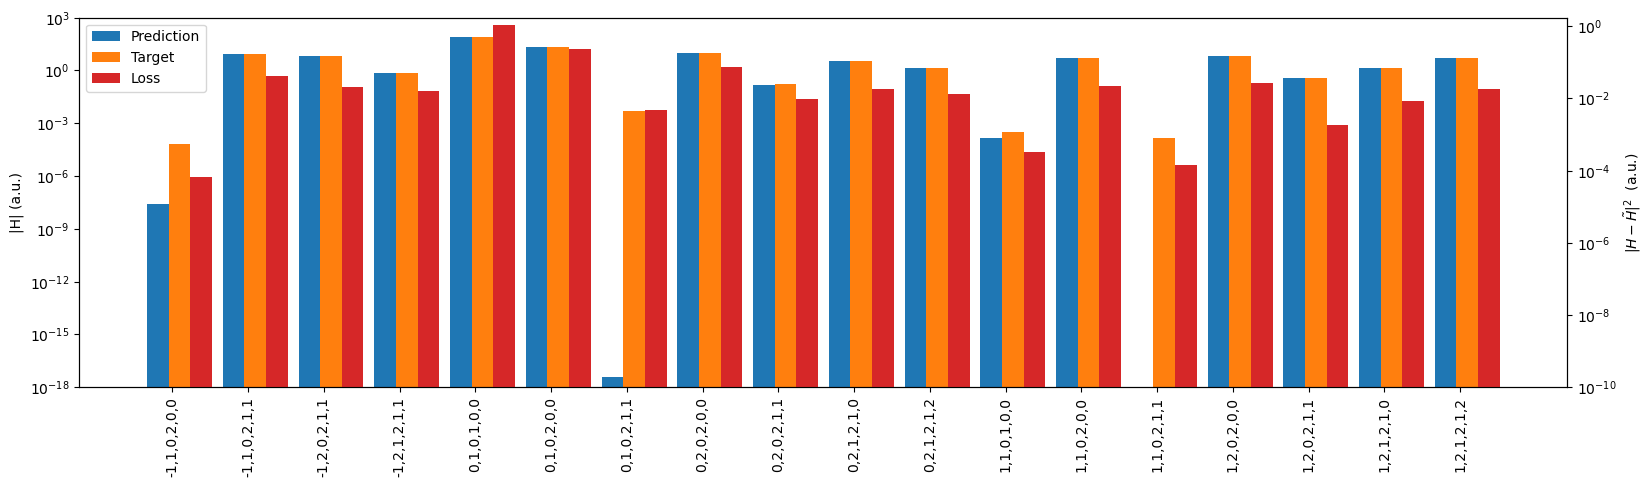

In [11]:
check = torch.load(f'/scratch/pegolo/benchmarks/real_space/a_direct_HT/train_0_140/model_950.ckpt')
    
model.load_state_dict(check['model_state_dict'])

pred_HT_blocks = model.predict(test_features, test_HT_blocks)

fig, ax1, ax2 = plot_block_errors(test_HT_blocks, pred_HT_blocks, plot_loss=True)
ax1.set_ylim(1e-18)

In [32]:
np.array([rfock0[i][0,0,0][0,0] - rfock[i][0,0,0][0,0] for i in range(32)])

array([0.14373749, 0.14044134, 0.13922365, 0.14170677, 0.15008971,
       0.13931898, 0.13636292, 0.14289178, 0.13932919, 0.13379281,
       0.1450813 , 0.13417465, 0.15122621, 0.13635444, 0.13932292,
       0.13616751, 0.13932214, 0.14339478, 0.14123826, 0.14415596,
       0.12888625, 0.15025246, 0.11673246, 0.14062321, 0.143124  ,
       0.12104207, 0.14919764, 0.13397831, 0.13386869, 0.12834788,
       0.14624804, 0.15177004])

(1e-18, 1000.0)

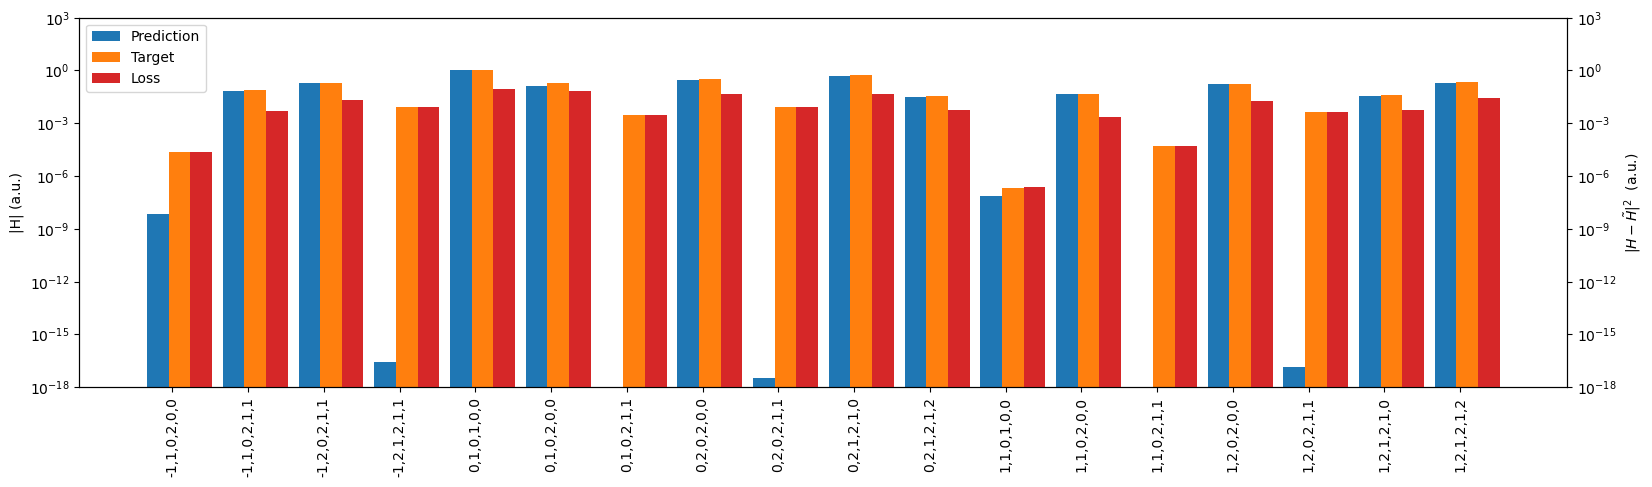

In [28]:
check = torch.load(f'/scratch/pegolo/benchmarks/real_space/b_baseline_direct_HT/train_0_80/model_50.ckpt')
    
model.load_state_dict(check['model_state_dict'])

pred_HT_blocks = model.predict(test_features, test_HT_blocks)

# fig, ax1, ax2 = plot_block_errors(test_HT_blocks, pred_HT_blocks, plot_loss=True)
# fig, ax1, ax2 = plot_block_errors(test_HT_blocks, baseline_blocks, plot_loss=True)
# fig, ax1, ax2 = plot_block_errors(mts.add(baseline_blocks, pred_HT_blocks), test_HT_blocks, plot_loss=True)
fig, ax1, ax2 = plot_block_errors(mts.subtract(test_HT_blocks, baseline_blocks), pred_HT_blocks, plot_loss=True)

ax1.set_ylim(1e-18, 1e3)
ax2.set_ylim(1e-18, 1e3)

In [19]:
from mlelec.utils.twocenter_utils import map_targetkeys_to_featkeys
feat = map_targetkeys_to_featkeys(test_features, test_HT_blocks.keys[6])

In [20]:
feat.values

tensor([[[-1.0701e-03, -4.2330e-03, -1.5601e-02,  ..., -1.3855e-03,
           3.5782e-04,  7.8105e-04],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-6.9213e-04, -2.3765e-03, -9.0619e-03,  ...,  2.4337e-03,
          -2.4401e-03, -2.3797e-03]],

        [[ 1.0701e-03,  4.2330e-03,  1.5601e-02,  ...,  1.3855e-03,
          -3.5782e-04, -7.8105e-04],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 6.9213e-04,  2.3765e-03,  9.0619e-03,  ..., -2.4337e-03,
           2.4401e-03,  2.3797e-03]],

        [[-1.3774e-03, -9.9573e-03, -1.8866e-02,  ...,  2.9378e-04,
           9.6024e-05, -4.4549e-04],
         [-8.9616e-04,  5.7952e-04, -1.2487e-02,  ..., -1.6296e-03,
          -1.3680e-03, -8.1218e-04],
         [-2.7006e-03, -1.6087e-02, -3.5818e-02,  ...,  6.5219e-05,
          -1.9880e-04, -6.0619e-04]],

        ...,

        [[ 3.1810e-03,  1.5780e-02,

(1e-18, 1000.0)

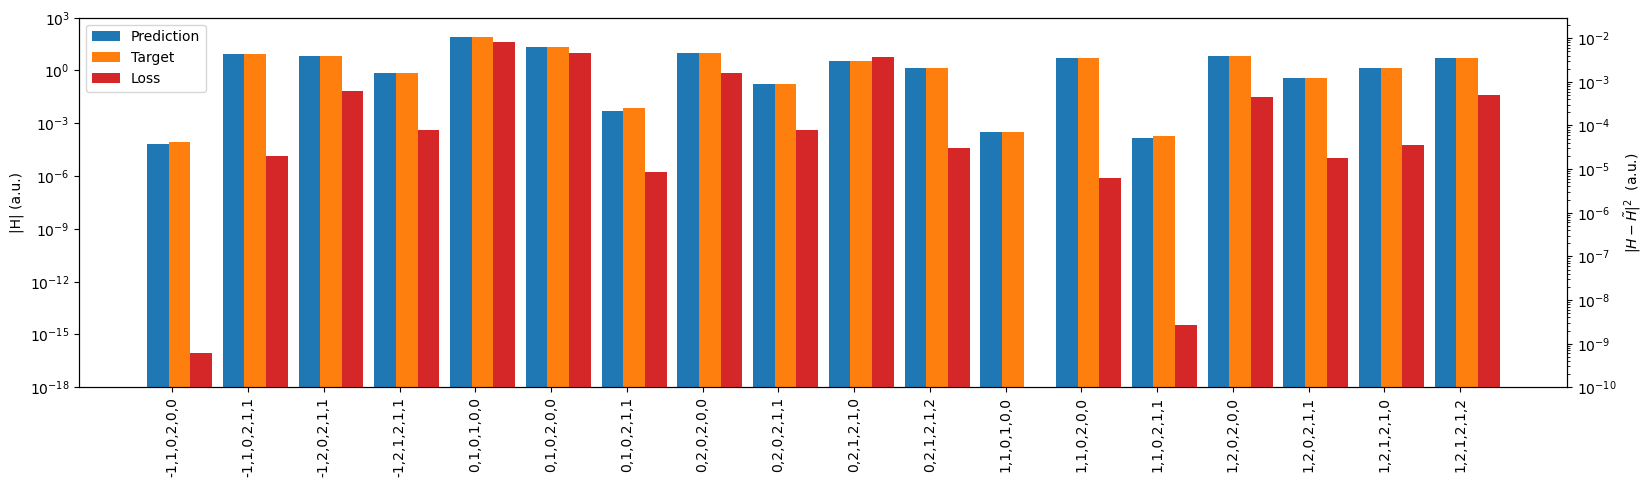

In [241]:
check = torch.load(f'/scratch/pegolo/benchmarks/real_space/c_traceless_learning_direct_HT/train_0_80/model_50.ckpt')
    
model.load_state_dict(check['model_state_dict'])

pred_HT_blocks = model.predict(test_features, test_HT_blocks)

fig, ax1, ax2 = plot_block_errors(mts.add(baseline_blocks, pred_HT_blocks), test_HT_blocks, plot_loss=True)
ax1.set_ylim(1e-18)

(<Figure size 1920x480 with 2 Axes>,
 <Axes: ylabel='|H| (a.u.)'>,
 <Axes: ylabel='$|H-\\tilde{H}|^2$  (a.u.)'>)

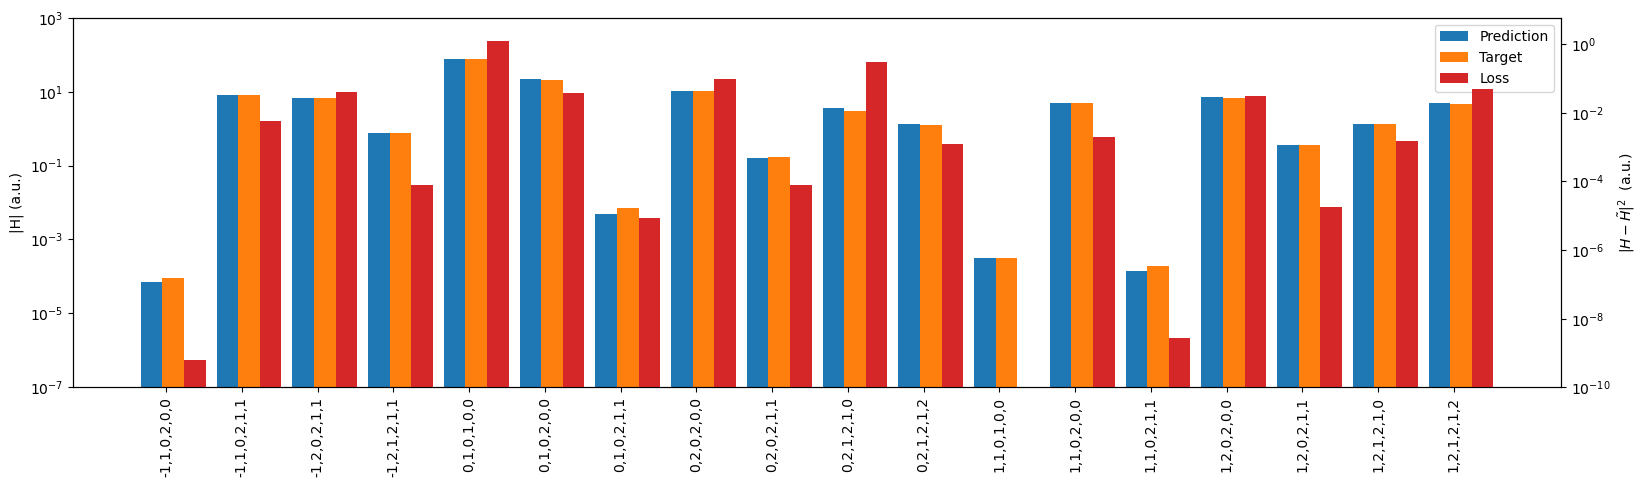

In [232]:
plot_block_errors(baseline_blocks, test_HT_blocks, plot_loss=True)

In [233]:
from mlelec.metrics import L2_loss

In [ ]:
L2_loss()